In [59]:
%cd /Users/rattie/Dev/sdo_tracking_framework
import os, glob
import time
import numpy as np
from scipy.io import readsav
import matplotlib.pyplot as plt
import fitstools
import fitsio
import balltracking.balltrack as blt
from astropy.io import fits
from scipy.ndimage.filters import gaussian_filter

/Users/rattie/Dev/sdo_tracking_framework


In [98]:
def balltrack_calibration(datafiles, fwhm, fov_slices, reprocess_bt, use_existing, outputdir):

    # Select only a subset of nframes files
    selected_files = datafiles[0:nframes]
    # Load the nt images
    images = fitstools.fitsread(selected_files)
    
    start_time_clock = time.clock()
    if reprocess_bt:
         # Must make even dimensions for the fast fourier transform
        images2 = np.zeros([264, 264, images.shape[2]])
        images2[0:263, 0:263, :] = images.copy()
        images2[263, :] = images.mean()
        images2[:, 263] = images.mean() 

        cal = blt.Calibrator(images2, drift_rates, nframes, rs, dp, sigma_factor, outputdir,
                             intsteps=intsteps,
                             output_prep_data=False, use_existing=use_existing,
                             nthreads=5)

        ballpos_top_list, ballpos_bottom_list = cal.balltrack_all_rates()
    else:
        print('Load existing tracked data at all rates')
        ballpos_top_list = np.load(os.path.join(outputdir, 'ballpos_top_list.npy'))
        ballpos_bottom_list = np.load(os.path.join(outputdir, 'ballpos_bottom_list.npy'))

    duration_time_clock = time.clock() - start_time_clock 
    print('duration_time_clock:   ', duration_time_clock)
    
    trange = [0, nframes]
    xrates = np.array(drift_rates)[:, 0]
    a_top, vxfit_top, vxmeans_top, residuals_top, vxs_top, vys_top = blt.fit_calibration(ballpos_top_list, xrates, trange, fwhm,
                                                        images.shape[0:2], fov_slices,
                                                        return_flow_maps=True)
    a_bottom, vxfit_bottom, vxmeans_bottom, residuals_bottom, vxs_bot, vys_bot = blt.fit_calibration(ballpos_bottom_list, xrates, trange, fwhm,
                                                                 images.shape[0:2], fov_slices,
                                                                 return_flow_maps=True)

    return a_top, vxfit_top, vxmeans_top, residuals_top, a_bottom, vxfit_bottom, vxmeans_bottom, residuals_bottom, vxs_top, vys_top, vxs_bot, vys_bot


def average_calibration(vxfit_top, vxfit_bottom, vx_rates):
    # Fit the averaged calibrated balltrack velocity
    vxmeans_bt = (vxfit_top + vxfit_bottom)/2
    # #vxmeans_bt -= vxmeans_bt[4]
    p = np.polyfit(vx_rates, vxmeans_bt, 1)
    a_avg = 1 / p[0]
    vxfit_avg = a_avg * (vxmeans_bt - p[1])
    # # Calculate residuals
    bt_residuals = np.abs(vxmeans_bt - vx_rates)
    #bt_residuals_fit = np.abs(vxfit_avg - vx_rates)
    print('a_avg = {:0.2f}, p[1] = {:0.2f}'.format(a_avg, p[1]))
    return vxmeans_bt, a_avg, vxfit_avg, bt_residuals



def dv_analysis(vx_files, vx_ratesu):
    # Benoit's data are already in physical units (m/s). The drift rates must also be in that unit.
    # Also, Benoit already cropped the field. So fov_slices should not be applied here. 
    vxmeans = []
    for i in range(len(vx_files)):
        vx = fitsio.read(vx_files[i])
        vxmeans.append(vx.mean())
    vxmeans = np.array(vxmeans)# - vxmeans[4]
    ## Calibration parameters: y_measured = p0*x_true + p1 => true = 1/p0*(measured - p1)
    p = np.polyfit(vx_ratesu, vxmeans, 1)
    a_v = 1 / p[0]
    vxfits = a_v * (vxmeans - p[1])
    # Calculate residuals
    residuals0 = np.abs(vxmeans - vx_ratesu)
    residuals = np.abs(vxfits - vx_ratesu)

    return vxmeans, a_v, vxfits, residuals0, residuals


In [96]:
# input data, list of files
# glob.glob does not order numbered files by defaultl, the order is as appeared in the file system.
datafiles = sorted(glob.glob('/Users/rattie/Data/Ben/SteinSDO/SDO_int*.fits'))
# directory for the drifting images that Balltracking need. 
driftdir = '/Users/rattie/Data/Ben/SteinSDO/calibration2/unfiltered'
# output directory for the plots
plotdir = '/Users/rattie/Data/Ben/SteinSDO/calibration2/unfiltered'
# Set if we balltrack again or use previous results
reprocess_bt = False
# Set if we use existing drifted images
use_existing = True
 
# Ball radius
rs = 2
# depth factor
dp = 0.3
# Multiplier to the standard deviation.
sigma_factor = 1
# Nb of integration steps between images
intsteps = 5

nframes = 80
fwhm = 7
dv = 0.02
vx_rates = np.arange(-0.2, 0.2+0.9*dv, dv)
# Make sure the middle of the drift value series is zero. 
idx0 = int(len(vx_rates)/2)
vx_rates[idx0] = 0
ndrifts = len(vx_rates)
# The drift can optionnally be on both direction, not just on the x-axis
drift_rates = np.stack((vx_rates, np.zeros(ndrifts)), axis=1).tolist()
# Select a subfield excluding edge effects
imsize = 263 # actual size is 264 but original size was 263 then padded to 264 to make it even for the Fourier transform
trim = int(vx_rates.max() * nframes + fwhm + 2)
fov_slices = np.s_[2*rs:imsize - 2*rs, trim:imsize-trim]

unit = 368000 / 60 # m/s
unit_str = '[m/s]'
vx_ratesu = vx_rates * unit
bar_labels = ['{:0.0f}'.format(vxrate) for vxrate in vx_ratesu]

## Balltracking

In [105]:
    # Select a subfield excluding edge effects
    fov_slices_bt = [fov_slices, ]
    ##########################################
    ######  Smoothing at FWHM = 7 px #########
    fwhm = 7
    a_top, vxfit_top, vxmeans_top, res_top, a_bot, vxfit_bot, vxmeans_bot, res_bot, vxs_top, vys_top, vxs_bot, vys_bot = balltrack_calibration(datafiles, fwhm, fov_slices_bt, reprocess_bt, use_existing, driftdir)
    vxmeans_bt, a_avg, vxfit_avg, bt_residuals = average_calibration(vxfit_top, vxfit_bot, vx_rates)

Load existing tracked data at all rates
duration_time_clock:    0.25791799999998943
a_avg = 1.00, p[1] = -0.00


In [31]:
# Benoit DeepVel data directory. 1 directory per drift value -> 9 directories for 9 drift values
data_dir = '/Users/rattie/Data/Ben/SteinSDO/calibration2/unfiltered/DeepVel_Drift_data_21_samples/'
dvx_files = [os.path.join(data_dir, 'drift_no_filtering_{:02d}'.format(i), 'Mean_drift_000-079', 'DeepVel_vx1_drift_000-079.fits') for i in range(ndrifts)]
dvy_files = [os.path.join(data_dir, 'drift_no_filtering_{:02d}'.format(i), 'Mean_drift_000-079', 'DeepVel_vy1_drift_000-079.fits') for i in range(ndrifts)]
dvx_files

['/Users/rattie/Data/Ben/SteinSDO/calibration2/unfiltered/DeepVel_Drift_data_21_samples/drift_no_filtering_00/Mean_drift_000-079/DeepVel_vx1_drift_000-079.fits',
 '/Users/rattie/Data/Ben/SteinSDO/calibration2/unfiltered/DeepVel_Drift_data_21_samples/drift_no_filtering_01/Mean_drift_000-079/DeepVel_vx1_drift_000-079.fits',
 '/Users/rattie/Data/Ben/SteinSDO/calibration2/unfiltered/DeepVel_Drift_data_21_samples/drift_no_filtering_02/Mean_drift_000-079/DeepVel_vx1_drift_000-079.fits',
 '/Users/rattie/Data/Ben/SteinSDO/calibration2/unfiltered/DeepVel_Drift_data_21_samples/drift_no_filtering_03/Mean_drift_000-079/DeepVel_vx1_drift_000-079.fits',
 '/Users/rattie/Data/Ben/SteinSDO/calibration2/unfiltered/DeepVel_Drift_data_21_samples/drift_no_filtering_04/Mean_drift_000-079/DeepVel_vx1_drift_000-079.fits',
 '/Users/rattie/Data/Ben/SteinSDO/calibration2/unfiltered/DeepVel_Drift_data_21_samples/drift_no_filtering_05/Mean_drift_000-079/DeepVel_vx1_drift_000-079.fits',
 '/Users/rattie/Data/Ben/Ste

In [102]:
# Loop through Benoit's matrix data
dvxmeans, a_dv, dvxfits, dv_residuals0, dv_residuals = dv_analysis(dvx_files, vx_ratesu)

In [103]:
# Setup some figure parameters
label = 'DeepVel'
# Default plot params
fs = 12
plt.rcParams.update({'font.size': fs})
markers = 'd'
colors = 'red'
legend_loc = 'lower right'
# Widths of bar plots
widths = [0.015, 0.015, 0.01]
# Plot figure file name suffix
fig_suffix = 'intsteps_{:d}_dp_{:0.2f}_sigma_factor_{:0.2f}'.format(intsteps, dp, sigma_factor)
dpi = 300

<IPython.core.display.Javascript object>


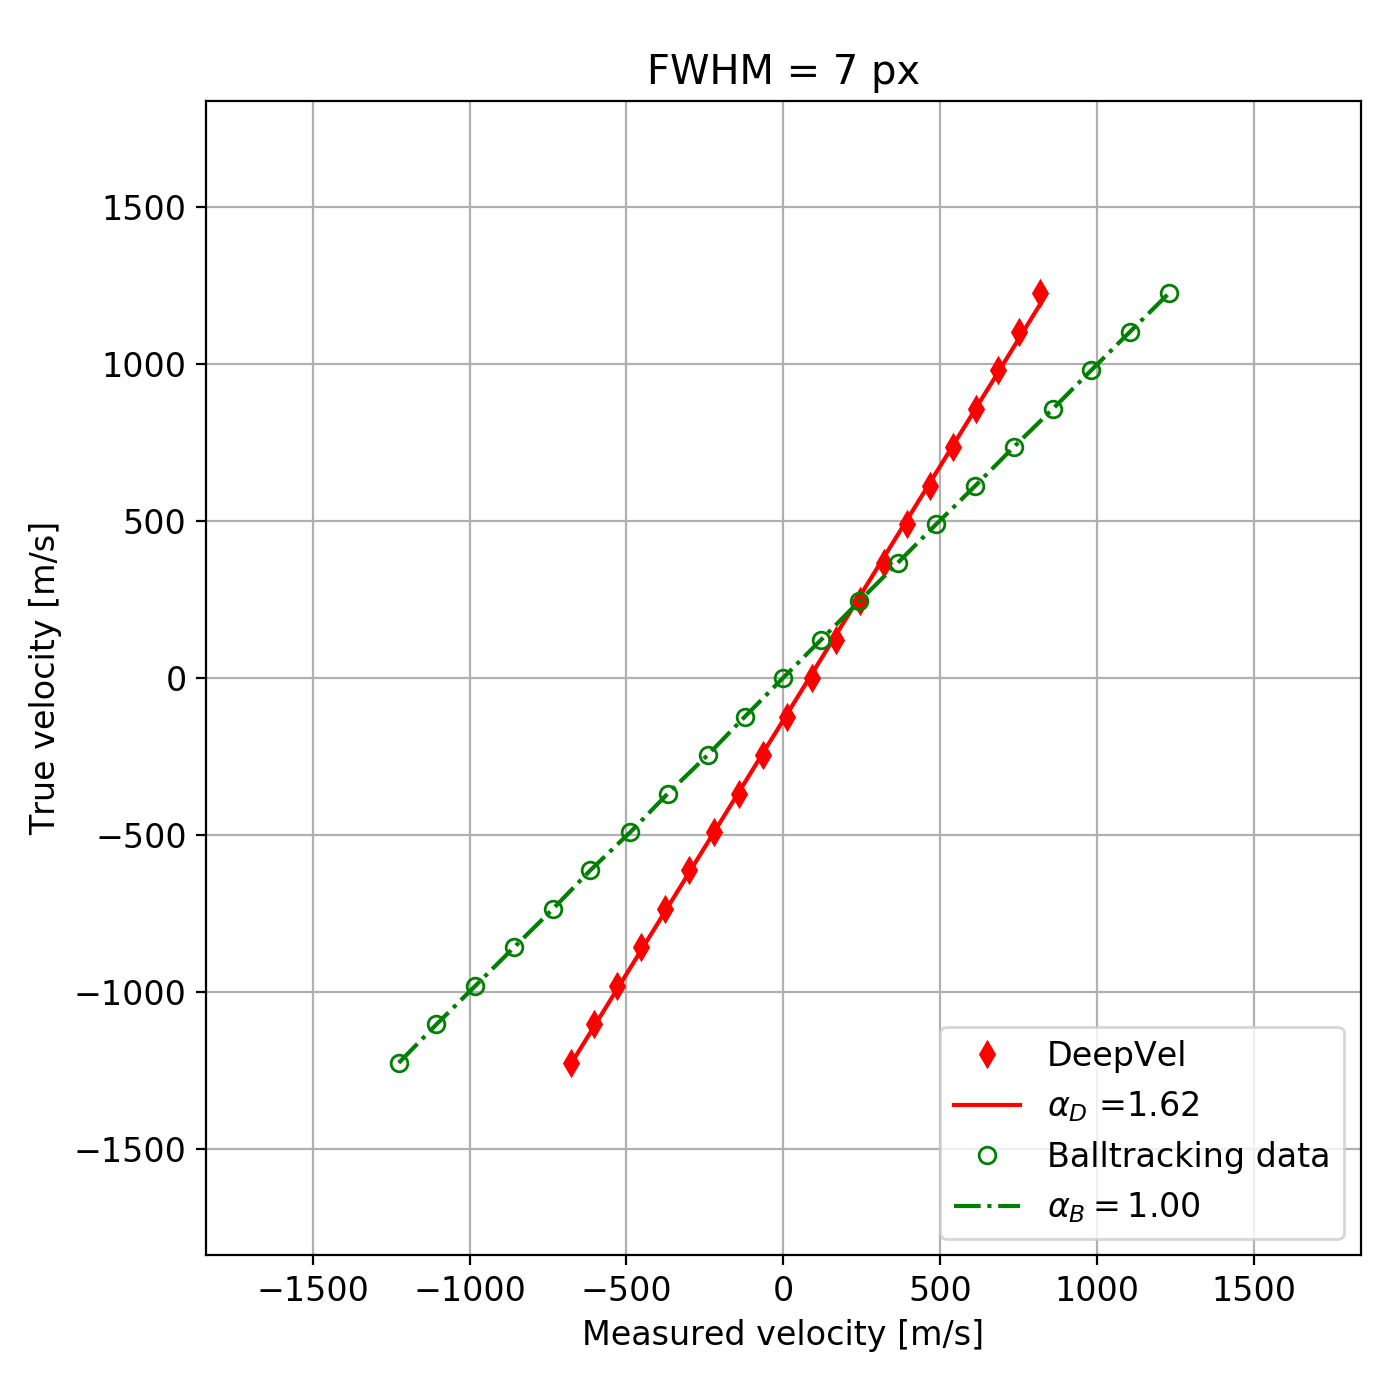

In [104]:
    maxv = 0.3 * unit

    %matplotlib notebook
    fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize=(7, 7))
    axs.set_title('FWHM = 7 px')
    # Consider only the unfiltered ones (the filtered ones do not work). range from 0 to 5 incl.
    axs.plot(dvxmeans, vx_ratesu, marker=markers, color=colors, ls='none', label=label)
    axs.plot(dvxmeans, dvxfits, color=colors, label=r'$\alpha_{:s}$ ={:0.2f}'.format('D', a_dv))

    axs.plot(vxmeans_bt * unit, vx_ratesu, marker='o', markerfacecolor='none', ls='none', color='green', label='Balltracking data')
    axs.plot(vxfit_avg * unit, vx_ratesu, ls='-.', color='green', label=r'$\alpha_B = {:0.2f}$'.format(a_avg))

    axs.axis([-maxv, maxv, -maxv, maxv])
    axs.set_xlabel('Measured velocity {:s}'.format(unit_str), fontsize=fs)
    axs.set_ylabel('True velocity {:s}'.format(unit_str), fontsize=fs)
    axs.legend(loc=legend_loc)
    axs.grid(True)
    axs.set_aspect('equal')

    plt.tight_layout()
    
    plt.savefig(os.path.join(plotdir, 'Benoit_DeepVel_calibration_21_samples_v2_{:s}.png'.format(fig_suffix)), dpi=dpi)

### Show uncorrected and corrected residuals

<IPython.core.display.Javascript object>


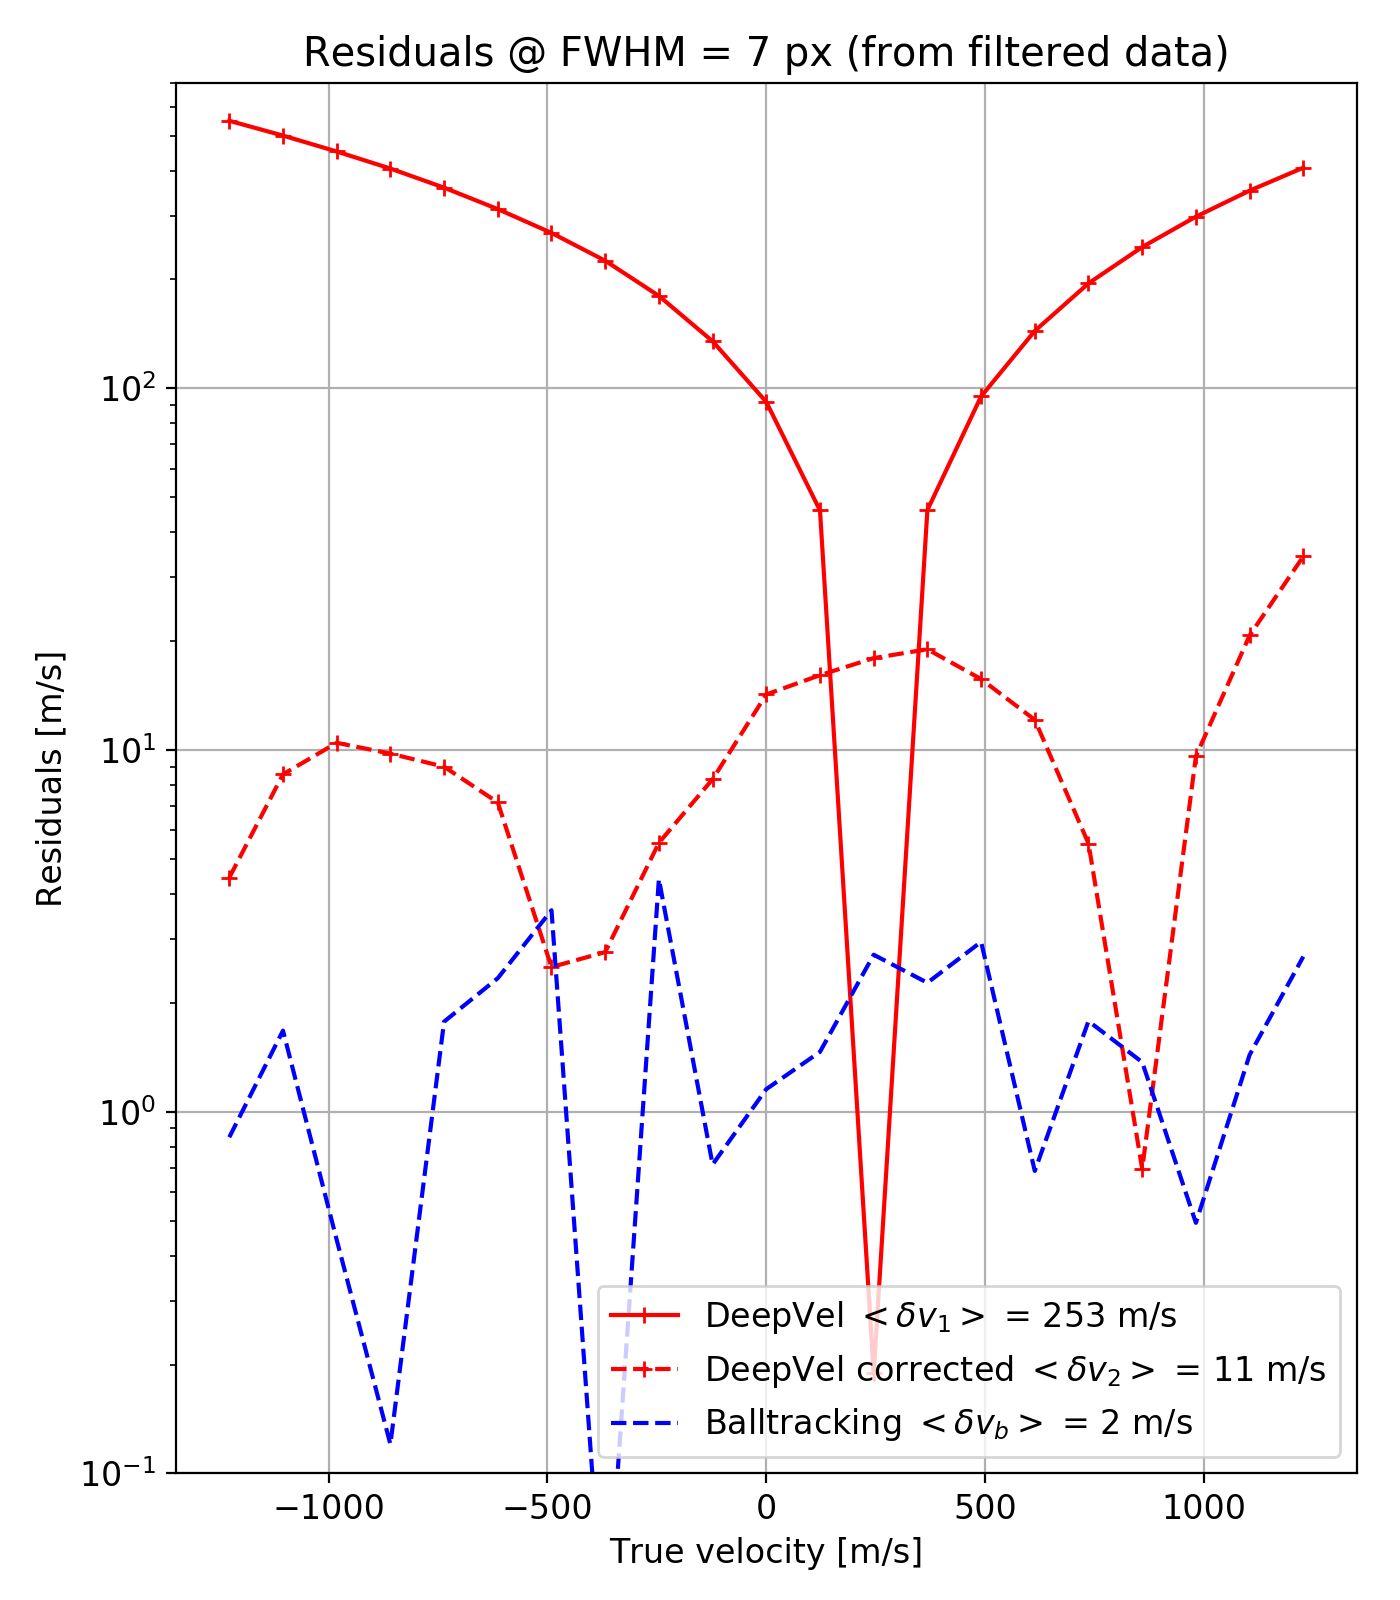

In [84]:
######################################
##### Residuals with linear correction
######################################

bt_residuals1u = bt_residuals1 * unit

max_resid1 = 700#0.1 * unit

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(7, 8))
axs.set_title('Residuals @ FWHM = 7 px (from filtered data)')
axs.set_xlabel('True velocity {:s}'.format(unit_str))
axs.set_ylabel('Residuals {:s}'.format(unit_str))
bar_labels = ['{:0.0f}'.format(vxrate) for vxrate in vx_ratesu]

width = widths[0]*0.7 * unit
axs.plot(vx_ratesu, dv_residuals0, 'r-', marker='+', label=r'DeepVel $<\delta v_{{1}}>$ = {:.0f} m/s'.format(dv_residuals0.mean()))
axs.plot(vx_ratesu, dv_residuals, 'r--', marker='+', label=r'DeepVel corrected $<\delta v_{{2}}>$ = {:.0f} m/s'.format(dv_residuals.mean()))
axs.plot(vx_ratesu, bt_residuals1u, 'b--', label=r'Balltracking $<\delta v_b>$ = {:.0f} m/s'.format(bt_residuals1u.mean()))
#axs[0].bar(vx_ratesu, bt_residuals1 * unit, width=widths[0]*0.7 * unit, color='green', tick_label=None, label='balltracking')
axs.set_yscale('log')
axs.set_ylim([0.1, max_resid1])
axs.legend()
axs.grid(True)


plt.tight_layout()

plt.savefig(os.path.join(plotdir, 'Benoit_DeepVel_residuals_v2_{:s}.png'.format(fig_suffix)), dpi=dpi)


# Calculate correlations with simulation

## DeepVel - simulation

In [301]:
def calc_c_pearson(vx1, vx2, vy1, vy2, fov=None):
    vx1f, vx2f, vy1f, vy2f = vx1[fov], vx2[fov], vy1[fov], vy2[fov]
    c_pearson = np.sum(vx1f*vx2f + vy1f*vy2f) / np.sqrt(np.sum(vx1f**2 + vy1f**2)*np.sum(vx2f**2 + vy2f**2))
    return c_pearson

def load_vel_mean(v_files, trange):
    
    vxs = []
    vys = []
    vx_files_subset = v_files[0][trange[0]:trange[1]]
    vy_files_subset = v_files[1][trange[0]:trange[1]]
    for vxf, vyf in zip(vx_files_subset, vy_files_subset):
        vxs.append(fitsio.read(vxf))
        vys.append(fitsio.read(vyf))

    # Get the mean of the velocity components
    vx = np.array(vxs).mean(axis=0)
    vy = np.array(vys).mean(axis=0)
    
    return vx, vy

def load_vels_mean(v_files1, v_files2, trange):
    vx1, vy1 = load_vel_mean(v_files1, trange)
    vx2, vy2 = load_vel_mean(v_files2, trange)
    return vx1, vy1, vx2, vy2

In [390]:
data_dir2 = '/Users/rattie/Data/Ben/SteinSDO/output_newDeepVel_without_edge_effect/' 
plot_dir2 = '/Users/rattie/Data/Ben/SteinSDO/comparisons'

frames = [29, 79]
tranges = ([0,frames[0]], [0,frames[1]])

# Simulation data
svx_files = sorted(glob.glob('/Users/rattie/Data/Ben/SteinSDO/SDO_vx*.fits'))
svy_files = sorted(glob.glob('/Users/rattie/Data/Ben/SteinSDO/SDO_vy*.fits'))
# Deepvel data
dvx_files = sorted(glob.glob(os.path.join(data_dir2, 'DeepVel_vx1_drift_*.fits')))
dvy_files = sorted(glob.glob(os.path.join(data_dir2, 'DeepVel_vy1_drift_*.fits')))
# Load both
vx_stein, vy_stein, vx_deepvel, vy_deepvel  = zip(*[load_vels_mean((svx_files, svy_files), (dvx_files, dvy_files), trange) for trange in tranges])
# smooth the Stein velocities with the same gaussian filter as Balltracking
sigma = fwhm/2.35
vx_stein = [gaussian_filter(v, sigma=sigma, order=0) for v in vx_stein]
vy_stein = [gaussian_filter(v, sigma=sigma, order=0) for v in vy_stein]
# Smooth deepvel 
vx_deepvel = [gaussian_filter(v, sigma=sigma, order=0) for v in vx_deepvel]
vy_deepvel = [gaussian_filter(v, sigma=sigma, order=0) for v in vy_deepvel]


### Calculate correlation coefficients

In [391]:
pads = np.arange(50)
c_pearsons = [[calc_c_pearson(vx_stein[i], vx_deepvel[i], vy_stein[i], vy_deepvel[i], fov=np.s_[pad:imsize - pad, pad:imsize-pad]) for pad in pads] for i in range(len(tranges))]


<IPython.core.display.Javascript object>


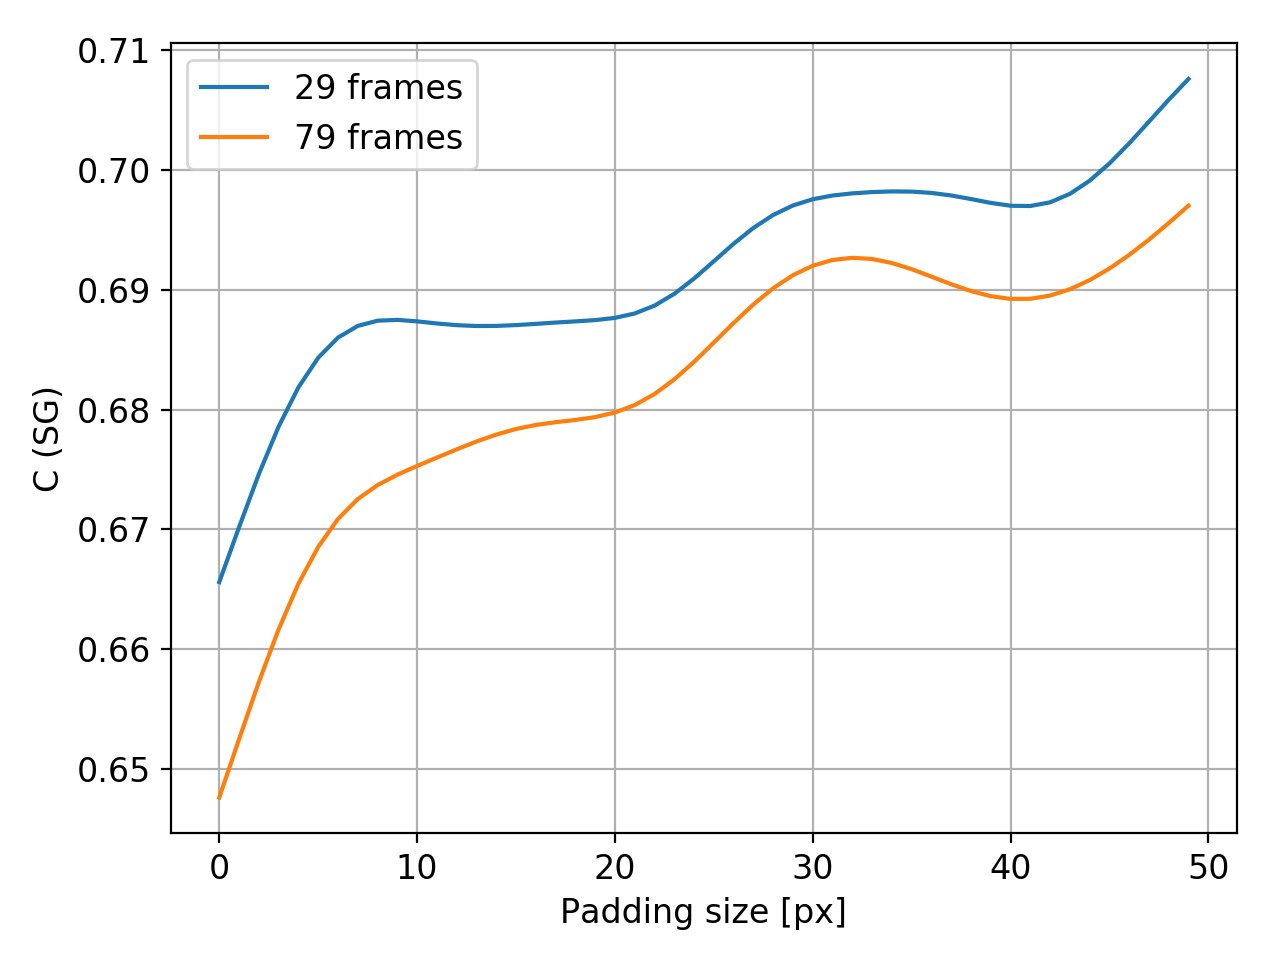

In [392]:
plt.figure()
for i in range(len(nframes)):
    plt.plot(pads, c_pearsons[i], label = '{:d} frames'.format(nframes[i]))
plt.xlabel('Padding size [px]')
plt.ylabel('C (SG)')
plt.grid(True)
#plt.title('DeepVel - Stein correlation vs padding @ {:d} frames'.format(nframes[0]))
#plt.ylim([0.8, 0.86])
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(plot_dir2, 'DeepVel_padding_effect.png'), dpi=dpi)

<IPython.core.display.Javascript object>


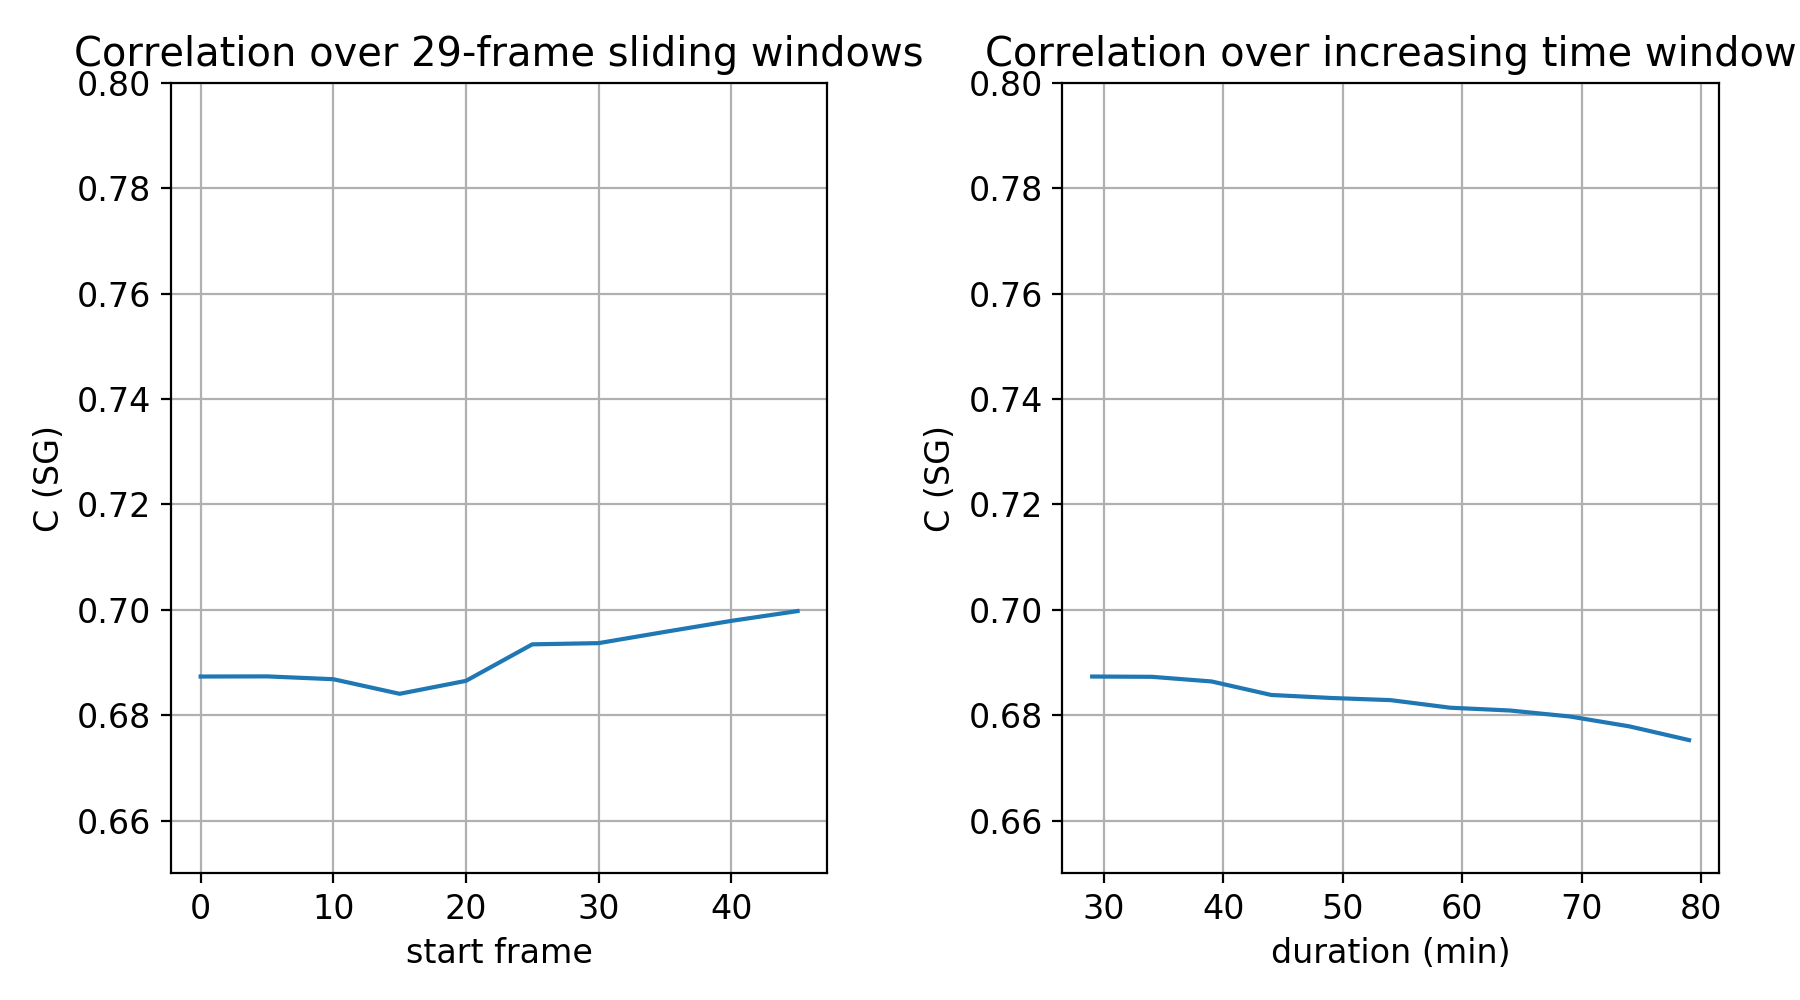

In [399]:
# Sliding windows

start_frames = np.arange(0,50,5)
duration = 29
tranges = [[f, f+duration] for f in start_frames]
# Load both
vx_stein, vy_stein, vx_deepvel, vy_deepvel  = zip(*[load_vels_mean((svx_files, svy_files), (dvx_files, dvy_files), trange) for trange in tranges])
# smooth the Stein velocities with the same gaussian filter as Balltracking
sigma = fwhm/2.35
vx_stein = [gaussian_filter(v, sigma=sigma, order=0) for v in vx_stein]
vy_stein = [gaussian_filter(v, sigma=sigma, order=0) for v in vy_stein]
# Smooth deepvel 
vx_deepvel = [gaussian_filter(v, sigma=sigma, order=0) for v in vx_deepvel]
vy_deepvel = [gaussian_filter(v, sigma=sigma, order=0) for v in vy_deepvel]
# Get correlations for one padding size, Tremblay et al. 2018 used pad = 10
pad = 10
c_pearsons = [calc_c_pearson(vx_stein[i], vx_deepvel[i], vy_stein[i], vy_deepvel[i], fov=np.s_[pad:imsize - pad, pad:imsize-pad]) for i in range(len(tranges))]

plt.figure(figsize=(9,5))
plt.subplot(1,2,1)
plt.plot(start_frames, c_pearsons)
plt.xlabel('start frame')
plt.ylabel('C (SG)')
plt.grid(True)
plt.title('Correlation over 29-frame sliding windows')
plt.ylim([0.65, 0.8])
plt.tight_layout()

# Over increasing time window size
twin = np.arange(29, 80, 5)
tranges2 = [[0, f] for f in twin]
# Load both
vx_stein, vy_stein, vx_deepvel, vy_deepvel  = zip(*[load_vels_mean((svx_files, svy_files), (dvx_files, dvy_files), trange) for trange in tranges2])
# smooth the Stein velocities with the same gaussian filter as Balltracking
sigma = fwhm/2.35
vx_stein = [gaussian_filter(v, sigma=sigma, order=0) for v in vx_stein]
vy_stein = [gaussian_filter(v, sigma=sigma, order=0) for v in vy_stein]
# Smooth deepvel 
vx_deepvel = [gaussian_filter(v, sigma=sigma, order=0) for v in vx_deepvel]
vy_deepvel = [gaussian_filter(v, sigma=sigma, order=0) for v in vy_deepvel]
# Get correlations for one padding size
pad = 10
c_pearsons = [calc_c_pearson(vx_stein[i], vx_deepvel[i], vy_stein[i], vy_deepvel[i], fov=np.s_[pad:imsize - pad, pad:imsize-pad]) for i in range(len(tranges2))]

plt.subplot(1,2,2)
plt.plot(twin, c_pearsons)
plt.xlabel('duration (min)')
plt.ylabel('C (SG)')
plt.grid(True)
plt.title('Correlation over increasing time window')
plt.ylim([0.65, 0.8])
plt.tight_layout()
plt.savefig(os.path.join(plot_dir2, 'DeepVel_correlation_SG_scales.png'), dpi=120)


### Load Balltracking data

In [405]:
def mean_bt_velocity(ballpos_top, ballpos_bot, tranges, fwhm, a_top, a_bot):
    dims = [263, 263]
    vxs_top, vys_top, _ = zip(*[blt.make_velocity_from_tracks(ballpos_top, dims, trange, fwhm) for trange in tranges])
    vxs_bot, vys_bot, _ = zip(*[blt.make_velocity_from_tracks(ballpos_bot, dims, trange, fwhm) for trange in tranges])
    vxs_top2 = [a_top * v for v in vxs_top]
    vys_top2 = [a_top * v for v in vys_top]
    vxs_bot2 = [a_bot * v for v in vxs_bot]
    vys_bot2 = [a_bot * v for v in vys_bot]

    vxs = [(vx_top + vx_bot)/2 for vx_top, vx_bot in zip(vxs_top2, vxs_bot2)]
    vys = [(vy_top + vy_bot)/2 for vy_top, vy_bot in zip(vys_top2, vys_bot2)]
    
    return vxs, vys, vxs_top2, vys_top2, vxs_bot2, vys_bot2

In [406]:
# Get balltracked, undrifted data, average flow at the different time slices
ballpos_top_list = np.load(os.path.join(driftdir, 'ballpos_top_list.npy'))
ballpos_bottom_list = np.load(os.path.join(driftdir, 'ballpos_bottom_list.npy'))

In [407]:
# Average the balltrack velocities
ballpos_top = ballpos_top_list[idx0]
ballpos_bot = ballpos_bottom_list[idx0]
# sliding window of fixed average time window
bvxs, bvys, vxs_top, vys_top, vxs_bot, vys_bot = mean_bt_velocity(ballpos_top, ballpos_bot, tranges, fwhm, a_top, a_bot)
# increasing average time window
bvxs2, bvys2, vxs_top2, vys_top2, vxs_bot2, vys_bot2 = mean_bt_velocity(ballpos_top, ballpos_bot, tranges2, fwhm, a_top, a_bot)



In [408]:
# Get correlations for the padding size set earlier (Tremblay et al. 2018 used pad = 10)

# over sliding window of fixed average time window
c_pearsons_b_top = [calc_c_pearson(vx_stein2[i], vxs_top[i], vy_stein2[i], vys_top[i], fov=np.s_[pad:imsize - pad, pad:imsize-pad]) for i in range(len(tranges))]
c_pearsons_b_bot = [calc_c_pearson(vx_stein2[i], vxs_bot[i], vy_stein2[i], vys_bot[i], fov=np.s_[pad:imsize - pad, pad:imsize-pad]) for i in range(len(tranges))]
c_pearsons_b = [calc_c_pearson(vx_stein2[i], bvxs[i], vy_stein2[i], bvys[i], fov=np.s_[pad:imsize - pad, pad:imsize-pad]) for i in range(len(tranges))]
# over an increasing average time window
c_pearsons_b_top2 = [calc_c_pearson(vx_stein2[i], vxs_top2[i], vy_stein2[i], vys_top2[i], fov=np.s_[pad:imsize - pad, pad:imsize-pad]) for i in range(len(tranges2))]
c_pearsons_b_bot2 = [calc_c_pearson(vx_stein2[i], vxs_bot2[i], vy_stein2[i], vys_bot2[i], fov=np.s_[pad:imsize - pad, pad:imsize-pad]) for i in range(len(tranges2))]
c_pearsons_b2 = [calc_c_pearson(vx_stein2[i], bvxs2[i], vy_stein2[i], bvys2[i], fov=np.s_[pad:imsize - pad, pad:imsize-pad]) for i in range(len(tranges2))]


<IPython.core.display.Javascript object>


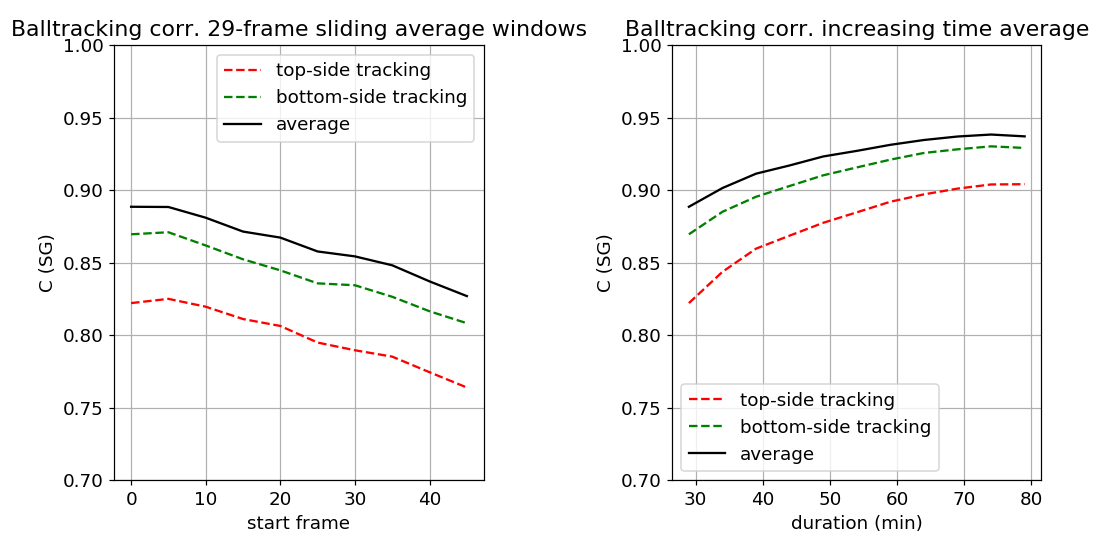

In [409]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(start_frames, c_pearsons_b_top, 'r--', label='top-side tracking')
plt.plot(start_frames, c_pearsons_b_bot, 'g--', label='bottom-side tracking')
plt.plot(start_frames, c_pearsons_b, color='black', label='average')
plt.xlabel('start frame')
plt.ylabel('C (SG)')
plt.grid(True)
plt.legend()
plt.title('Balltracking corr. 29-frame sliding average windows')
plt.ylim([0.7, 1.0])

plt.subplot(1,2,2)
plt.plot(twin, c_pearsons_b_top2, 'r--', label='top-side tracking')
plt.plot(twin, c_pearsons_b_bot2, 'g--', label='bottom-side tracking')
plt.plot(twin, c_pearsons_b2, color='black', label='average')
plt.xlabel('duration (min)')
plt.ylabel('C (SG)')
plt.grid(True)
plt.legend()
plt.title('Balltracking corr. increasing time average')
plt.ylim([0.7, 1.0])

plt.tight_layout()

plt.savefig(os.path.join(plot_dir2, 'Balltrack_correlation_sliding_increasing_time_window.png'), dpi=120)

<IPython.core.display.Javascript object>


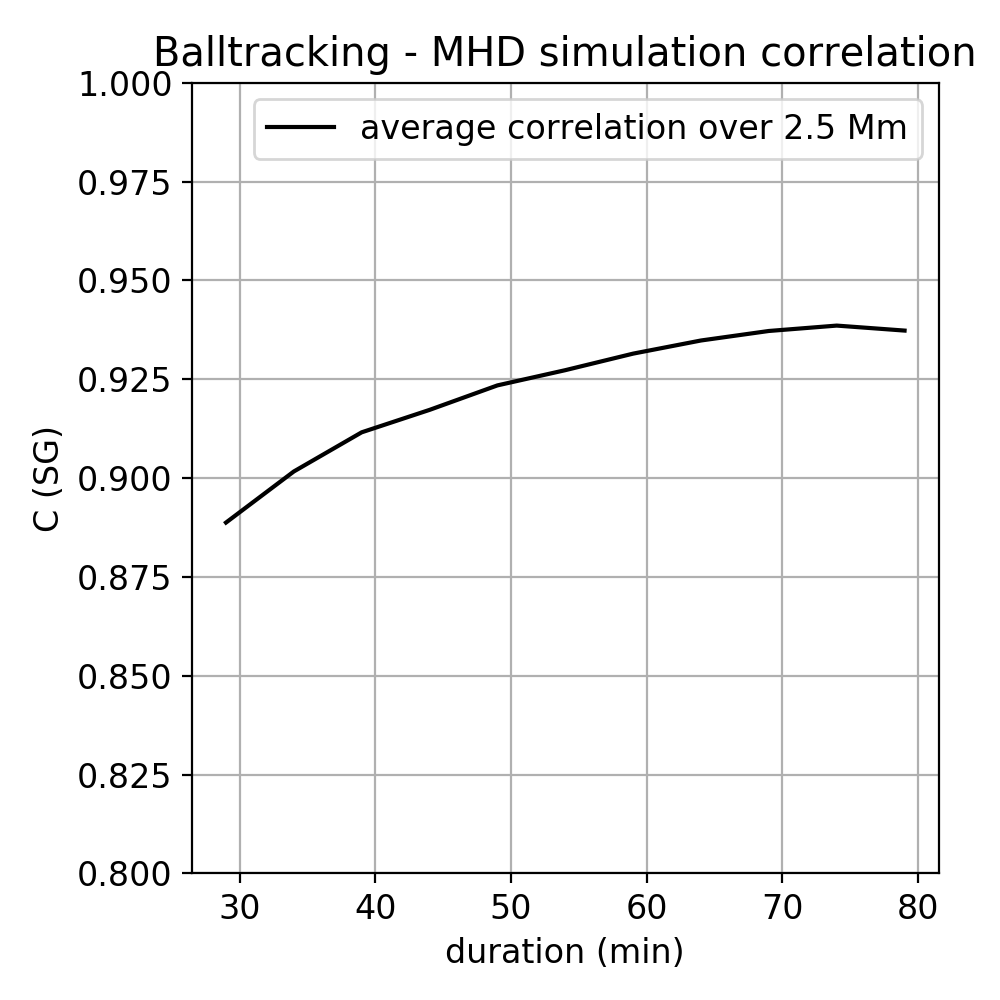

In [376]:
plt.figure(figsize=(5,5))

# plt.plot(twin, c_pearsons_b_top2, 'r--', label='top-side tracking')
# plt.plot(twin, c_pearsons_b_bot2, 'g--', label='bottom-side tracking')
plt.plot(twin, c_pearsons_b2, color='black', label='average correlation over 2.5 Mm')
plt.xlabel('duration (min)')
plt.ylabel('C (SG)')
plt.grid(True)
plt.legend()
plt.title('Balltracking - MHD simulation correlation')
plt.ylim([0.8, 1.0])

plt.tight_layout()

plt.savefig(os.path.join(plot_dir2, 'Balltrack_correlation_increasing_time_window.png'), dpi=120)

In [402]:
a_top

1.305688680696122

In [403]:
a_bot

1.2088067611490292

In [404]:
pwd

'/Users/rattie/Dev/sdo_tracking_framework'